<a href="https://colab.research.google.com/github/human-centered-ai-lab/app-covid-19-playground/blob/master/covid_19_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Read the data values

In [0]:
from datetime import timedelta, date
import matplotlib.pyplot as plt
from scipy import signal
import psycopg2 as ps
import seaborn as sns
import pandas as pd
import numpy  as np
import requests
import math
import json

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

r = requests.get(url = "https://pomber.github.io/covid19/timeseries.json") 
data = r.json() 

countries = sorted(data.keys())
print ("ALL COUNTRIES WITH DATA AVAILABLE at pomber.github.io")
print (countries)

countriesOfInterest = ['Austria', 'Belgium','Czechia', 'Denmark', 'Finland', 'France', 'Germany', 'Hungary',  'Italy', 'Malta','Netherlands',  'Portugal', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'US', 'United Kingdom']
population = {}
for c in countriesOfInterest:
  r = requests.get(url = "https://restcountries.eu/rest/v2/name/" + c) 
  cinforeq = r.json() 
  if ( r.status_code == 200):
      population[c] = cinforeq[0]['population']
  else:
      population[c] = 999999999999999999999999
population.update ({'Czechia' : 10703551})
population.update ({'US' : 330467650})

print ("COUNTRIES OF INTEREST WITH POPULATION")
print (population)

start_date = date(2020, 3, 8)
end_date   = date(2020, 3, 29)

/usr/local/lib/python3.6/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


ALL COUNTRIES WITH DATA AVAILABLE at pomber.github.io
['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria', 'Burkina Faso', 'Burma', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada', 'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia', 'Denmark', 'Diamond Princess', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Grenada', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary', 'Iceland


# Number of Cases (logarthmic scale) per 1.000.000 inhabitants



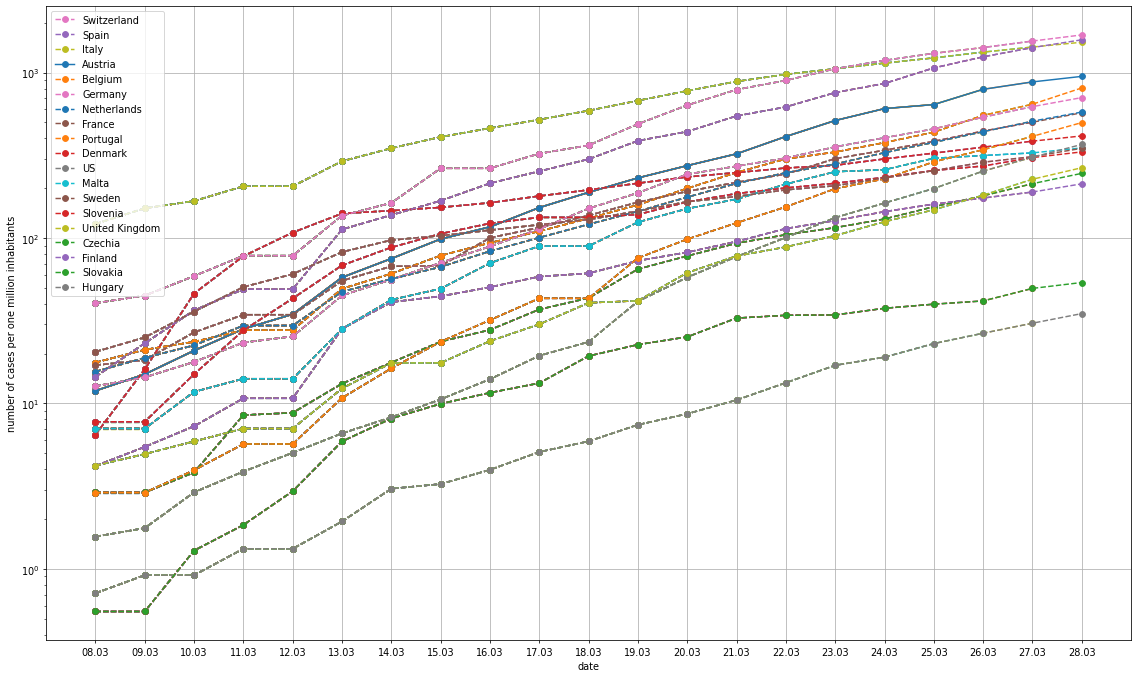

In [0]:
width_in_inches = 20
height_in_inches = 12
dots_per_inch = 70

plt.figure( figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)

#countriesOfInterest = ['Austria', 'Czechia', 'Germany', 'Italy', 'US', 'United Kingdom', 'Denmark' ]

datesToInspect = []
x_axis_data = [];
for single_date in daterange(start_date, end_date):
    x_axis_data.append(single_date.strftime("%d.%m"))
    datesToInspect.append(single_date.strftime("%Y-%-m-%-d"))

    lines = []
    labels = []
    numberToOrder = {}
    i = 0
    for c in countriesOfInterest:
        y_axis_data = []
        for dataindex in datesToInspect:
            datafromonecontry = data[c]
            for daydata in datafromonecontry:
                #print (daydata['date'], dataindex)
                if daydata['date'] == dataindex:
                    cc = daydata['confirmed']
                    normalizedcc = cc * 1000000 / population[c]
                    v = normalizedcc
                    numberToOrder[i] = v
                    y_axis_data.append(v)
        ls = 'solid' if c == 'Austria' else '--'    
        lines, = plt.plot(x_axis_data,  y_axis_data, label=c, linestyle=ls, marker='o')
        labels.append (c)
        plt.legend( )
        i = i + 1

LabelOrdering = []
for e in sorted(numberToOrder.items(), key=lambda x: x[1], reverse=True):
  LabelOrdering.append (e[0])

plt.yscale('log')
plt.xlabel("date")
plt.ylabel("number of cases per one million inhabitants")
plt.grid(True)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[idx] for idx in LabelOrdering],[labels[idx] for idx in LabelOrdering], loc='upper left')
plt.show()



# **Growth rate**

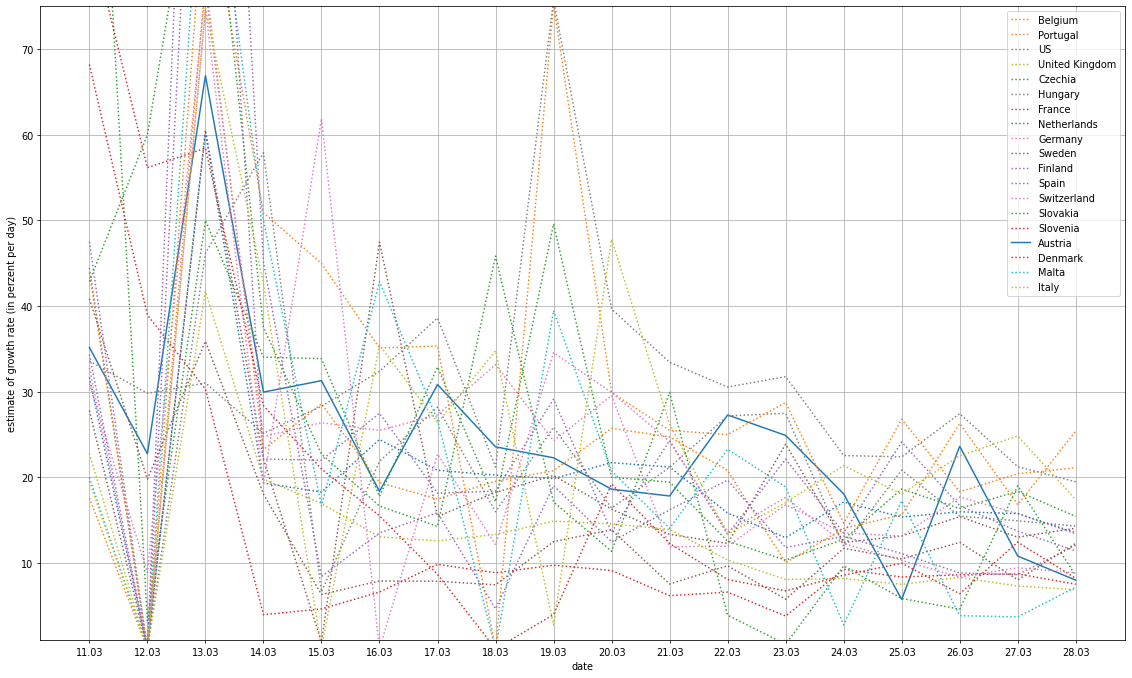

In [6]:
# delta growth rate computing
deltaInDays = 1
#countriesOfInterest = ['Austria',  'Czechia', 'Germany', 'Italy', 'US', 'Denmark']

start_date = date(2020, 3, 10)
datesToInspect = []

x_axis_data = [];
for single_date in daterange(start_date, end_date):
    x_axis_data.append(single_date.strftime("%d.%m"))
    datesToInspect.append(single_date.strftime("%Y-%-m-%-d"))

lines = []
labels = []

plt.figure( figsize=(width_in_inches, height_in_inches), dpi=dots_per_inch)
numberOfDays = len(datesToInspect)

numberToOrder = {}
i = 0
plt.ylim(1, 75)
for c in countriesOfInterest:
  y_axis_data = [];
  for dataindex in range(numberOfDays-deltaInDays):
    datafromonecontry = data[c]
    datastring = datesToInspect[dataindex]
    cc1 = 0
    cc2 = 0
    for daydata in datafromonecontry:
      if daydata['date'] == datastring:
          cc1 = daydata['confirmed']
    datastring = datesToInspect[dataindex+deltaInDays]
    for daydata in datafromonecontry:
      if daydata['date'] == datastring:
          cc2 = daydata['confirmed']
    if cc2 == 0:
      v = 0
    else:       
      v = 100 * (cc2-cc1) / cc1  / deltaInDays
    numberToOrder[i] = v
    y_axis_data.append(v)

  ls = 'solid' if c == 'Austria' else 'dotted'
  lines, = plt.plot(x_axis_data[deltaInDays:],  y_axis_data, label=c, linestyle=ls)
  labels.append (c)
  plt.legend()
  i = i + 1 

LabelOrdering = []
for e in sorted(numberToOrder.items(), key=lambda x: x[1], reverse=True):
  LabelOrdering.append (e[0])

plt.xlabel("date")
plt.ylabel("estimate of growth rate (in perzent per day)")
plt.grid(True)
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend([handles[idx] for idx in LabelOrdering],[labels[idx] for idx in LabelOrdering])
plt.show()
